In [1]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np

import jax
import jax.numpy as jnp
from functools import partial

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

In [2]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

In [3]:
def logger(params, X, Y, f):
    w2w1 = params["network"]["layer-1"]["w"][0] @ params["network"]["layer-0"]["w"][0]
    Y_hat = params["network"]["layer-1"]["w"][0] @ f(params["network"]["layer-0"]["w"][0] @ X.T)
    loss = 0.5 * np.mean(np.sum((Y_hat.T - Y)**2, axis=1))
    return w2w1, loss

In [4]:
def balanced_weights(in_dim, hidden_dim, out_dim, c):
    w1 = np.eye(hidden_dim, in_dim) * np.sqrt(c + 1)
    w2 = np.eye(out_dim, hidden_dim)

    return w1, w2

In [9]:
np.random.seed(2)

in_dim = 10
hidden_dim = 10
out_dim = 6

batch_size = 25
learning_rate = 0.01
training_steps = 6000

initial_weight_scale = 0.0001

num_tasks = 1

training_datas = []
for i in range(num_tasks):
    # init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=0.3)
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)

losses = [[] for _ in range(num_tasks)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []

#for each training data
#repeat for n training_steps
#for each data in training_data
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        # init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=0.3)
        init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):

        #why are we looping over the dataset again?
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    X, Y = training_data(None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    analyticals.append(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))

ws = np.asarray(ws)
losses = np.asarray(losses)
analyticals = np.asarray(analyticals)

ValueError: x and y must have same first dimension, but have shapes (6000,) and (0, 30)

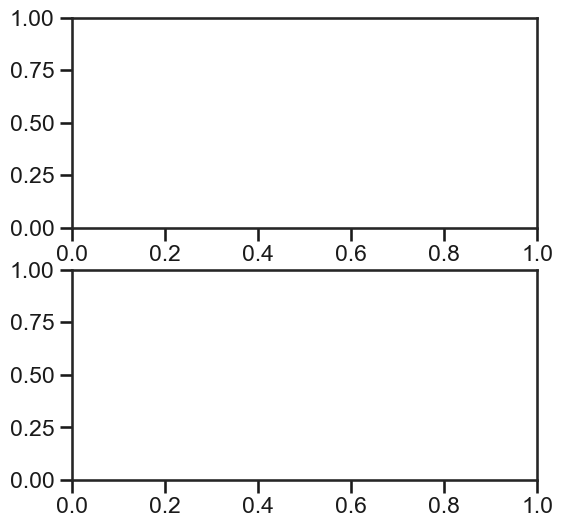

In [10]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, num_tasks)] + [training_steps * num_tasks - 1])):
    start = rng - training_steps
    end = rng
    axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=num_tasks)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=num_tasks)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-.25, .31)
axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
#axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, 20001, 5000))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()
fig.savefig("./figures/figure-5_a.svg")

AttributeError: 'AxesSubplot' object has no attribute 'set_xtick'

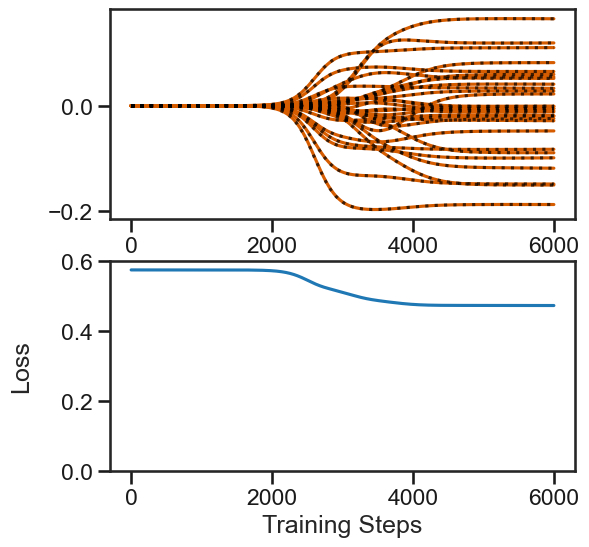

In [11]:
#Now, I would also like to plot what happens for just the first one.

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

loss = losses[0]

axs[1].plot(loss)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")
axs[1].set_ylim(0, 0.6)


axs[0].plot(ws.reshape(-1, in_dim*out_dim), c = blind_colours[0])
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
axs[0].set_xtick([])


plt.plot(loss)

ws





In [41]:
loss[-10:]

array([0.46677375, 0.46677375, 0.46677375, 0.46677375, 0.46677375,
       0.46677375, 0.46677375, 0.46677375, 0.46677375, 0.46677375],
      dtype=float32)